# Particle simulation vs Langevin model

In [1]:
using ProgressMeter
using Revise

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [3]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [4]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>500,
        "bounds"=>((0.,20.),(0.,20.)), 
        "radius"=>0.08, 
        "speed"=>0.03,
    )

growthParams =
    Dict(
        "ρ"=> 0.03,
        "k"=> 2000,
        "randGrowth"=> false,
        "waitTime"=> 200
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

Dict{String,Any} with 7 entries:
  "volume"     => 400.0
  "evolveTime" => 500
  "speed"      => 0.03
  "radius"     => 0.08
  "bounds"     => ((0.0, 20.0), (0.0, 20.0))
  "bperiod"    => [20.0, 20.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 200
  "k"          => 2000
  "ρ"          => 0.03
  "randGrowth" => false

### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


Run Langevin simulations:

In [6]:
langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.00045


Run a particle simulation:

In [26]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


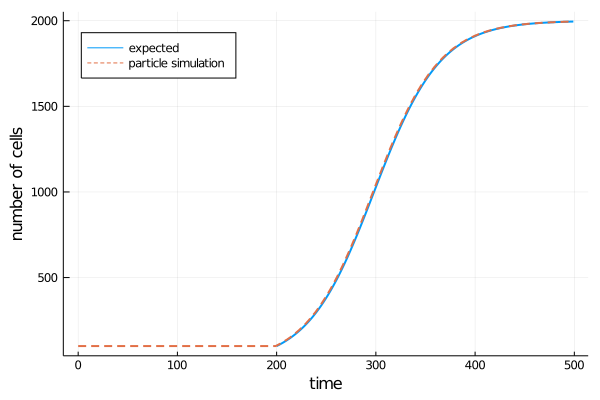

In [30]:
f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
        Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]), 
        label="expected", linewidth=2, legend=:topleft)
plot!(0:(arenaParams["evolveTime"]-1), BParts.nCellsTime(cells_T_ID)[1:end], linestyle=:dash, 
    label="particle simulation", linewidth=2)
xlabel!("time")
ylabel!("number of cells")
display(f1)

Ensemble of particle simulations:

In [9]:
nSims = 100

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams; 
                    progress=false, verbose=false);
            pos_Sim[i] = posSim_t_dim_id
        catch e
           continue 
        end
        succes = true
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:51


### Mean squared displacement

In [10]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

(201, 500)

In [11]:
msd_Sim = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, arena.bounds, msdTimes)).(pos_Sim);
msdAv_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdAv_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim ])
end

In [12]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )
# msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

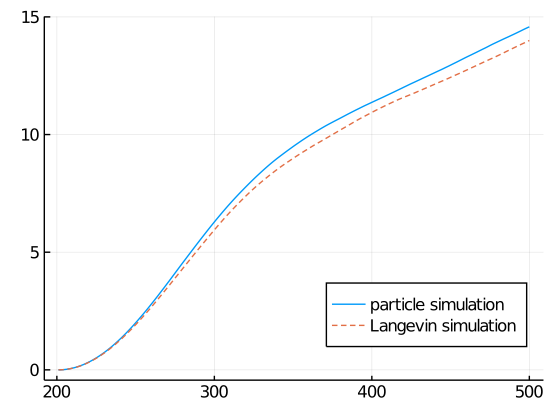

In [32]:
p2 = plot(timesMSD_t, msdAv_t, label="particle simulation", legend=:bottomright, size=(400,300),dpi=140)
plot!(timesMSD_t, msdLan_t, label="Langevin simulation", linestyle=:dash)
display(p2)

# savefig(p2, "../Figures/growingPop_msd.png")